## 1. Importar Librerías

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU disponible: []


---

# MODELO 1: Solo Imágenes (22 clases)

---

## 1.1. Configuración y Carga de Datos de Imágenes

In [2]:
data_dir = './data/images'
img_height, img_width = 224, 224
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator_img = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator_img = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names_img = list(train_generator_img.class_indices.keys())
num_classes_img = len(class_names_img)

print(f"\nClases de imágenes encontradas: {num_classes_img}")
print(f"Nombres de clases: {class_names_img}")
print(f"\nMuestras de entrenamiento: {train_generator_img.samples}")
print(f"Muestras de validación: {val_generator_img.samples}")

Found 5463 images belonging to 22 classes.
Found 1353 images belonging to 22 classes.

Clases de imágenes encontradas: 22
Nombres de clases: ['Dental Disease in Cat', 'Dental Disease in Dog', 'Distemper in Dog', 'Ear Mites in Cat', 'Eye Infection in Cat', 'Eye Infection in Dog', 'Feline Leukemia', 'Feline Panleukopenia', 'Fungal Infection in Cat', 'Fungal Infection in Dog', 'Hot Spots in Dog', 'Kennel Cough in Dog', 'Mange in Dog', 'Parvovirus in Dog', 'Ringworm in Cat', 'Scabies in Cat', 'Skin Allergy in Cat', 'Skin Allergy in Dog', 'Tick Infestation in Dog', 'Urinary Tract Infection in Cat', 'Worm Infection in Cat', 'Worm Infection in Dog']

Muestras de entrenamiento: 5463
Muestras de validación: 1353


## 1.2. Construcción del Modelo de Imágenes

In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model_img = MobileNetV2(
    include_top=False, 
    input_tensor=Input(shape=(img_height, img_width, 3)), 
    weights='imagenet'
)
base_model_img.trainable = False

x = base_model_img.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions_img = Dense(num_classes_img, activation='softmax')(x)

model_img = Model(inputs=base_model_img.input, outputs=predictions_img)
model_img.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

model_img.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,286,166 (8.72 MB)

 Trainable params: 28,182 (110.09 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 1.3. Entrenamiento del Modelo de Imágenes

In [4]:
callbacks_img = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'model/model_images.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configurados para modelo de imágenes")

Callbacks configurados para modelo de imágenes


In [5]:
history_img = model_img.fit(
    train_generator_img,
    validation_data=val_generator_img,
    epochs=100,
    callbacks=callbacks_img,
    verbose=1
)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0524 - loss: 3.9984
Epoch 1: val_accuracy improved from None to 0.09534, saving model to model/model_images.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.0588 - loss: 3.8262 - val_accuracy: 0.0953 - val_loss: 3.1384 - learning_rate: 1.0000e-04
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0709 - loss: 3.6101
Epoch 2: val_accuracy improved from 0.09534 to 0.13599, saving model to model/model_images.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.0734 - loss: 3.5582 - val_accuracy: 0.1360 - val_loss: 2.8889 - learning_rate: 1.0000e-04
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0929 - loss: 3.3969
Epoch 3: val_accuracy improved from 0.13599 to 0.17738, saving model to model/model_images.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.0981 - loss: 3.3528 - val_accuracy: 0.1774 - val_loss: 2.7226 - learning_rate: 1.0000e-04
Epoch 4/100
86/86 ━━━━━━━━━━

## 1.4. Evaluación del Modelo de Imágenes

In [6]:
val_generator_img.reset()
Y_pred_img = model_img.predict(val_generator_img)
y_pred_img = np.argmax(Y_pred_img, axis=1)
y_true_img = val_generator_img.classes

print(classification_report(y_true_img, y_pred_img, target_names=class_names_img, zero_division=0))

22/22 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step
                                precision    recall  f1-score   support

         Dental Disease in Cat       0.78      0.85      0.82        62
         Dental Disease in Dog       0.79      0.84      0.81        68
              Distemper in Dog       0.72      0.51      0.60        45
              Ear Mites in Cat       0.91      0.62      0.74        52
          Eye Infection in Cat       0.64      0.68      0.66        65
          Eye Infection in Dog       0.79      0.81      0.80        54
               Feline Leukemia       0.50      0.66      0.57        47
          Feline Panleukopenia       0.75      0.53      0.62        45
       Fungal Infection in Cat       0.69      0.34      0.46        64
       Fungal Infection in Dog       0.65      0.68      0.66        65
              Hot Spots in Dog       0.59      0.77      0.67        71
           Kennel Cough in Dog       0.67      0.72      0.69        64
                  Mange 

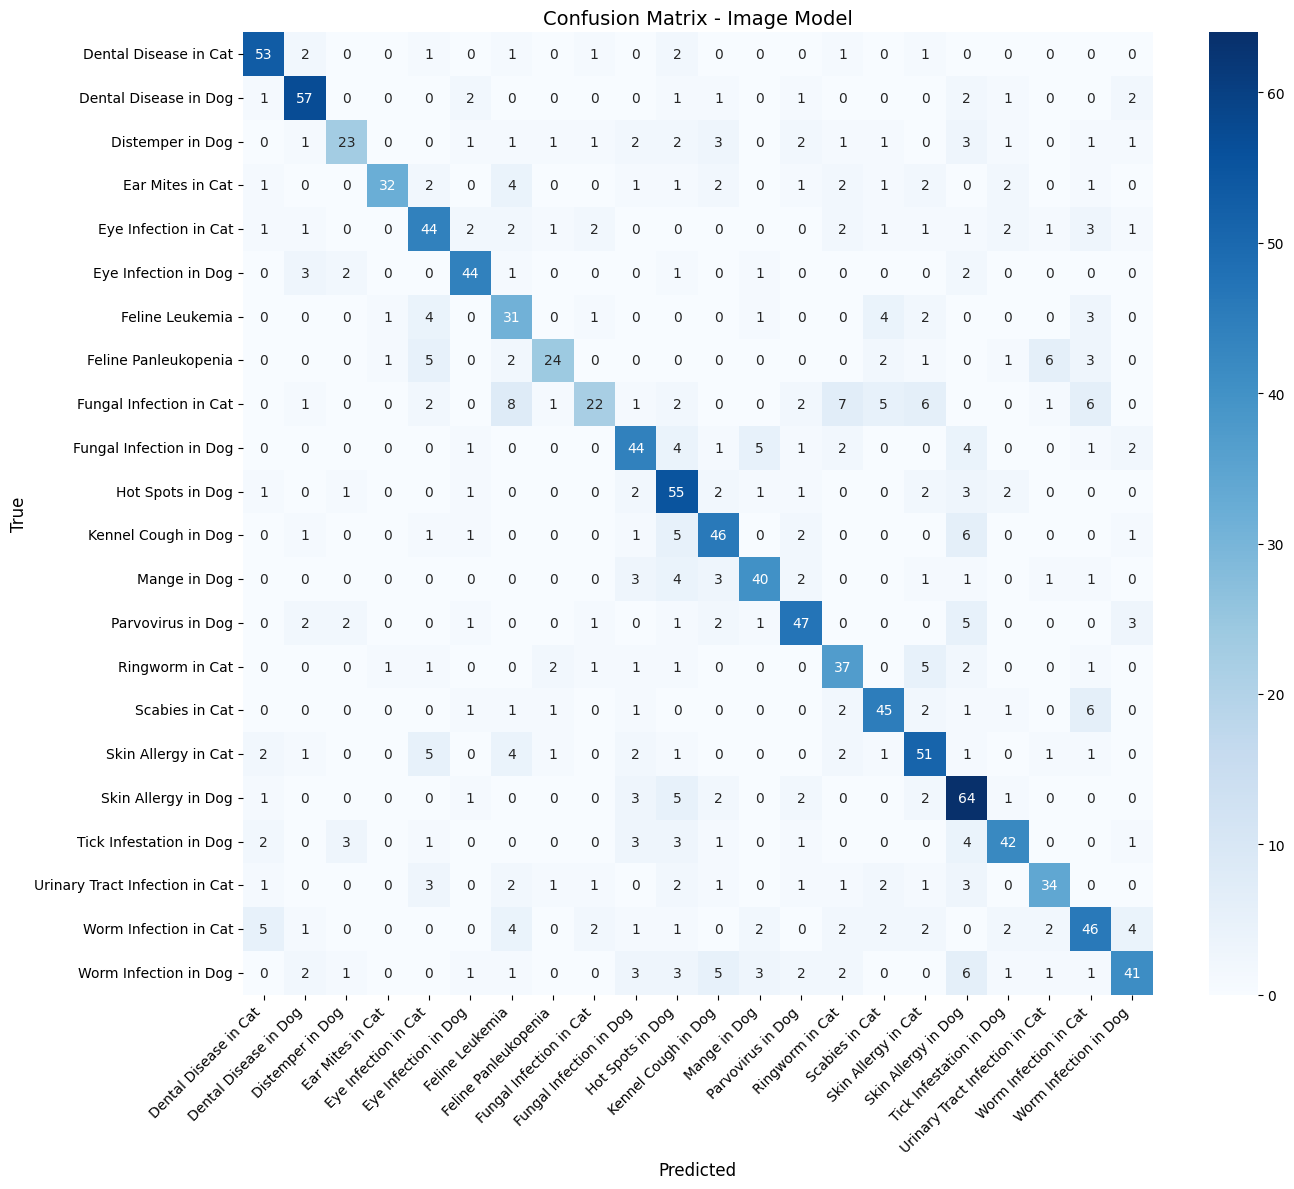

In [7]:
# Matriz de Confusión
cm_img = confusion_matrix(y_true_img, y_pred_img)
plt.figure(figsize=(14, 12))
sns.heatmap(cm_img, annot=True, fmt="d", xticklabels=class_names_img, yticklabels=class_names_img, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix - Image Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

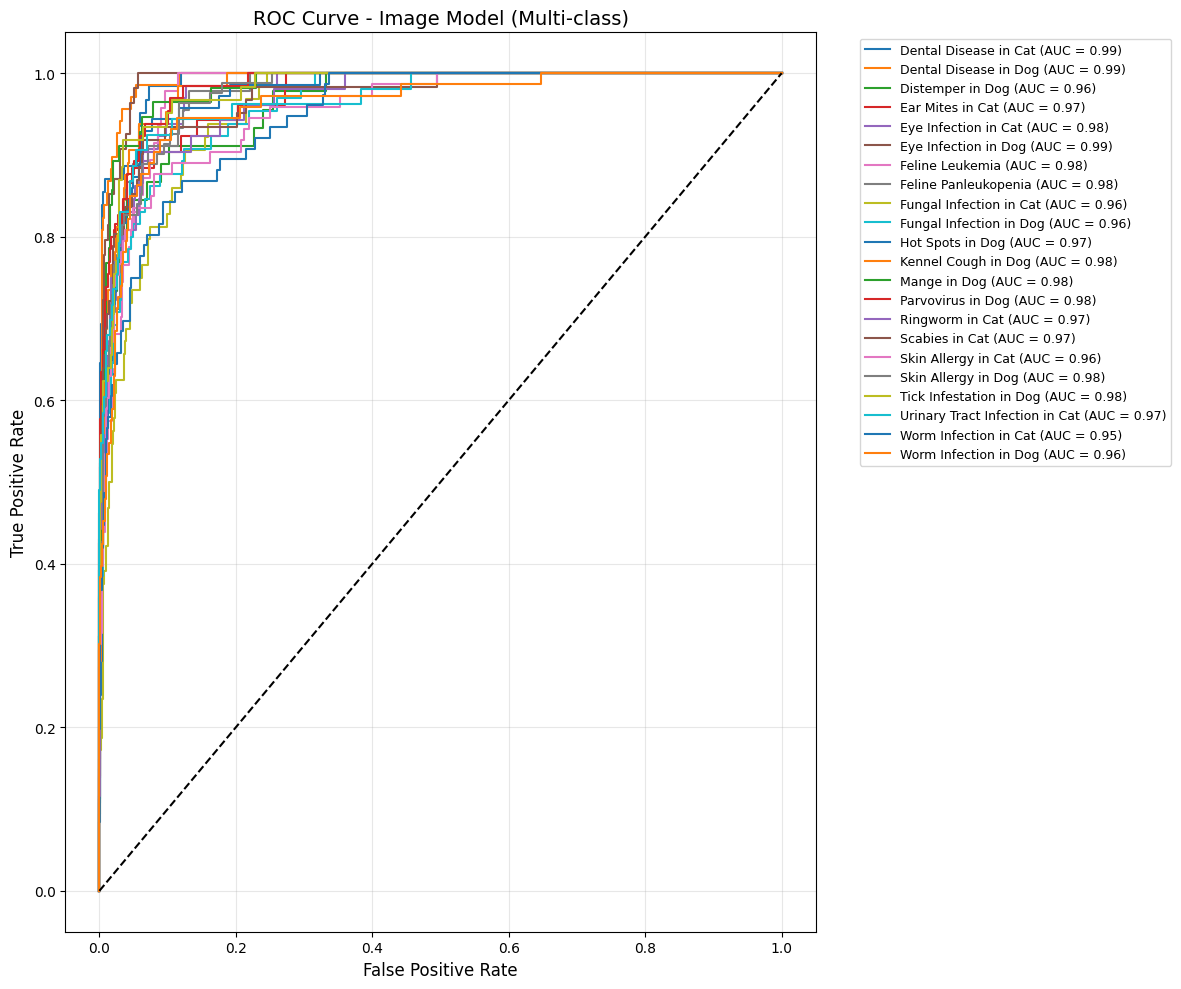

In [8]:
# Curvas ROC
fpr_img = {}
tpr_img = {}
roc_auc_img = {}

y_true_bin_img = to_categorical(y_true_img, num_classes=num_classes_img)
for i in range(num_classes_img):
    fpr_img[i], tpr_img[i], _ = roc_curve(y_true_bin_img[:, i], Y_pred_img[:, i])
    roc_auc_img[i] = auc(fpr_img[i], tpr_img[i])

plt.figure(figsize=(12, 10))
for i in range(num_classes_img):
    plt.plot(fpr_img[i], tpr_img[i], label=f"{class_names_img[i]} (AUC = {roc_auc_img[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve - Image Model (Multi-class)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

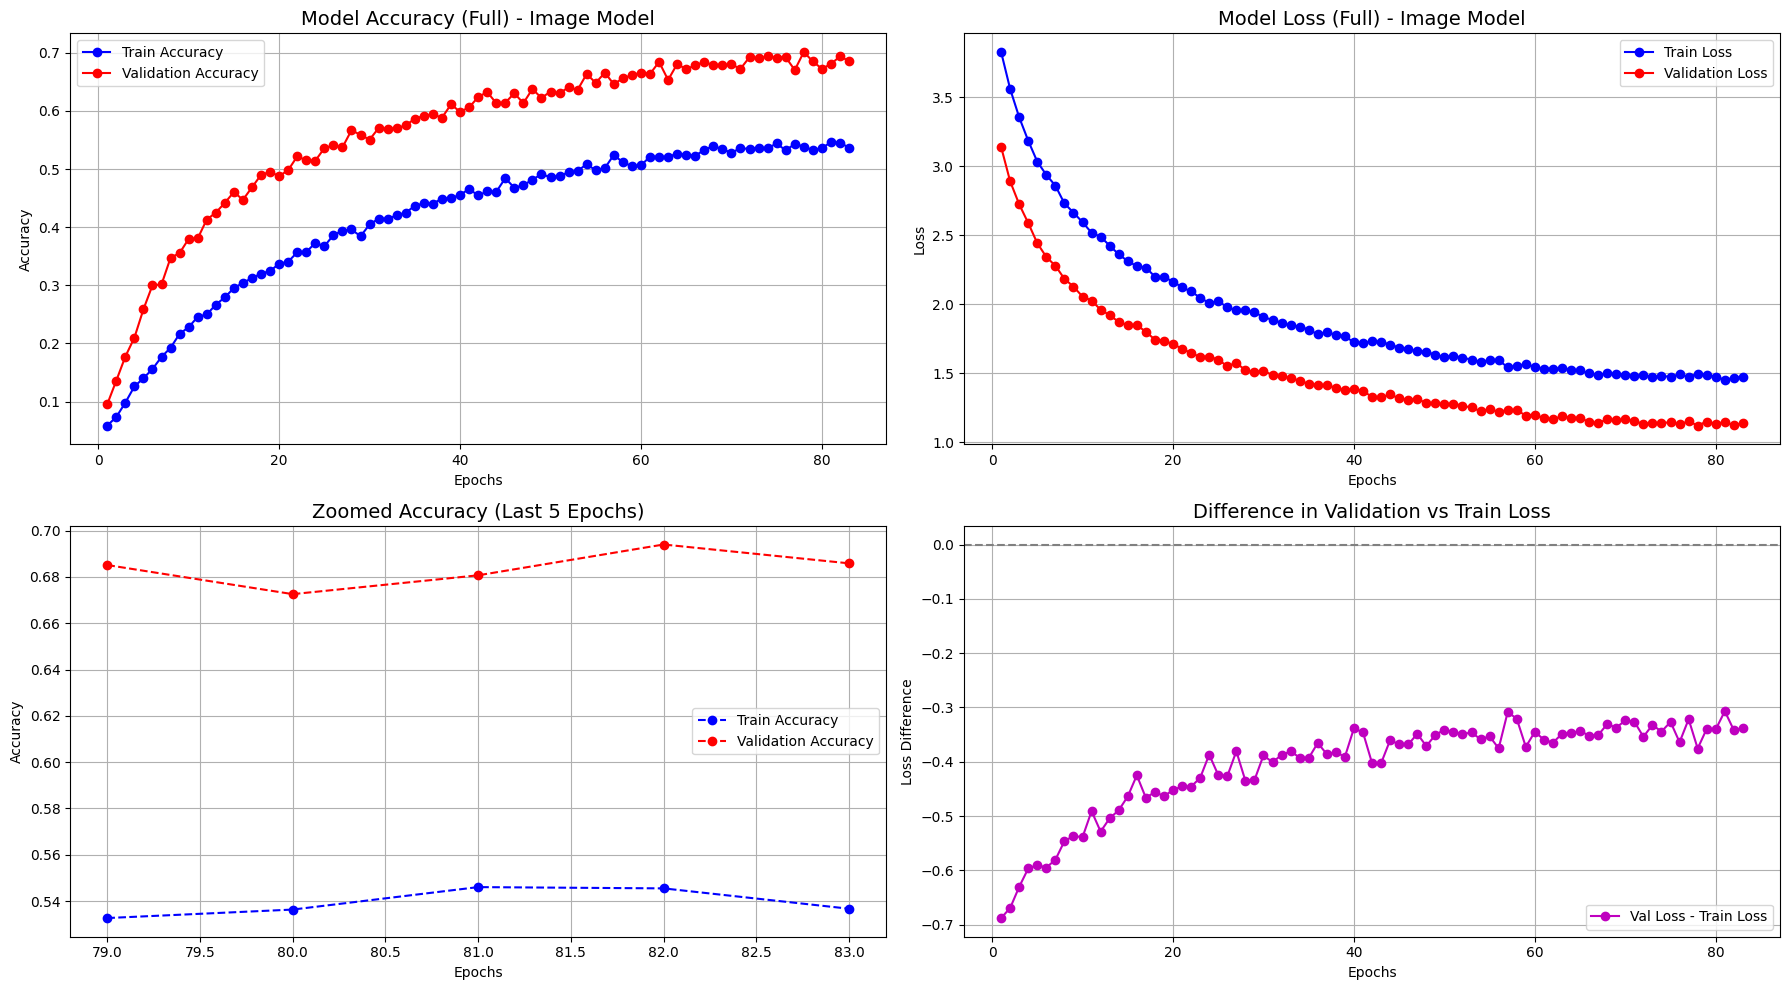

In [9]:
# Curvas de Entrenamiento
acc_img = history_img.history['accuracy']
val_acc_img = history_img.history['val_accuracy']
loss_img = history_img.history['loss']
val_loss_img = history_img.history['val_loss']
epochs_range_img = range(1, len(acc_img) + 1)

plt.figure(figsize=(18, 10))

# 1. Full Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(epochs_range_img, acc_img, 'bo-', label='Train Accuracy')
plt.plot(epochs_range_img, val_acc_img, 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy (Full) - Image Model', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. Full Loss Plot
plt.subplot(2, 2, 2)
plt.plot(epochs_range_img, loss_img, 'bo-', label='Train Loss')
plt.plot(epochs_range_img, val_loss_img, 'ro-', label='Validation Loss')
plt.title('Model Loss (Full) - Image Model', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. Zoomed-in Accuracy (Last 5 Epochs)
if len(epochs_range_img) >= 5:
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range_img[-5:], acc_img[-5:], 'bo--', label='Train Accuracy')
    plt.plot(epochs_range_img[-5:], val_acc_img[-5:], 'ro--', label='Validation Accuracy')
    plt.title('Zoomed Accuracy (Last 5 Epochs)', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# 4. Train vs. Validation Loss Difference
plt.subplot(2, 2, 4)
loss_diff_img = np.array(val_loss_img) - np.array(loss_img)
plt.plot(epochs_range_img, loss_diff_img, 'mo-', label='Val Loss - Train Loss')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Difference in Validation vs Train Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

---

# MODELO 2: Solo Datos Tabulares

---

## 2.1. Preparación de Datos Tabulares

In [10]:
# Cargar datos tabulares
df = pd.read_csv('./data/animal_disease_prediction_cleaned.csv')

print(f"Forma del dataset: {df.shape}")
print(f"\nClases de enfermedades: {df['Disease_Prediction'].nunique()}")
print(f"\nDistribución de clases:")
print(df['Disease_Prediction'].value_counts())

Forma del dataset: (17640, 22)

Clases de enfermedades: 31

Distribución de clases:
Disease_Prediction
Parvovirus               3000
Flu                      1680
Distemper                1440
Cough                    1320
Gastroenteritis          1080
Respiratory Infection    1080
Leukemia                  960
Peritonitis               960
Leptospirosis             840
Herpes                    840
Pancreatitis              480
Hepatitis                 480
Panleukopenia             360
Asthma                    360
Intestinal Parasites      240
Lyme Disease              240
Fungal Infection          240
Respiratory Disease       240
Heartworm                 240
Chlamydia                 240
Arthritis                 120
Ringworm                  120
Tick-Borne Disease        120
Kidney Disease            120
Allergic Rhinitis         120
IBD                       120
Bronchitis                120
Conjunctivitis            120
Hyperthyroidism           120
Coronavirus               1

In [12]:
print(f"Muestras: {len(df)}")
print(f"Clases: {df['Disease_Prediction'].nunique()}")
print(f"Enfermedades: {df['Disease_Prediction'].unique()}")

Muestras: 17640
Clases: 31
Enfermedades: ['Parvovirus' 'Respiratory Infection' 'Gastroenteritis' 'Fungal Infection'
 'Lyme Disease' 'Intestinal Parasites' 'Distemper' 'Panleukopenia' 'Cough'
 'Ringworm' 'Tick-Borne Disease' 'Arthritis' 'Herpes' 'Leukemia'
 'Heartworm' 'Peritonitis' 'Conjunctivitis' 'Bronchitis' 'Pancreatitis'
 'Flu' 'IBD' 'Allergic Rhinitis' 'Kidney Disease' 'Hyperthyroidism'
 'Hepatitis' 'Respiratory Disease' 'Leptospirosis' 'Chlamydia'
 'Coronavirus' 'Asthma' 'FIV']


In [13]:
# Preparar datos tabulares para el modelo tabular-only
label_encoders_tab = {}
categorical_cols_tab = ['Animal_Type', 'Breed', 'Gender', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4']

for col in categorical_cols_tab:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders_tab[col] = le

feature_cols_tab = [
    'Animal_Type_encoded', 'Breed_encoded', 'Age', 'Gender_encoded', 'Weight',
    'Symptom_1_encoded', 'Symptom_2_encoded', 'Symptom_3_encoded', 'Symptom_4_encoded',
    'Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing', 'Labored_Breathing',
    'Lameness', 'Skin_Lesions', 'Nasal_Discharge', 'Eye_Discharge',
    'Body_Temperature', 'Heart_Rate', 'Duration_days'
]

X_tabular_only = df[feature_cols_tab].values

disease_encoder_tab = LabelEncoder()
y_labels_tab = disease_encoder_tab.fit_transform(df['Disease_Prediction'])
num_classes_tab = len(disease_encoder_tab.classes_)

print(f"\nNúmero de características tabulares: {X_tabular_only.shape[1]}")
print(f"Número de clases (modelo tabular): {num_classes_tab}")
print(f"Clases: {disease_encoder_tab.classes_}")
print(f"Total de muestras: {len(X_tabular_only)}")


Número de características tabulares: 21
Número de clases (modelo tabular): 31
Clases: ['Allergic Rhinitis' 'Arthritis' 'Asthma' 'Bronchitis' 'Chlamydia'
 'Conjunctivitis' 'Coronavirus' 'Cough' 'Distemper' 'FIV' 'Flu'
 'Fungal Infection' 'Gastroenteritis' 'Heartworm' 'Hepatitis' 'Herpes'
 'Hyperthyroidism' 'IBD' 'Intestinal Parasites' 'Kidney Disease'
 'Leptospirosis' 'Leukemia' 'Lyme Disease' 'Pancreatitis' 'Panleukopenia'
 'Parvovirus' 'Peritonitis' 'Respiratory Disease' 'Respiratory Infection'
 'Ringworm' 'Tick-Borne Disease']
Total de muestras: 17640


In [15]:
# División de datos tabulares
X_train_tab, X_temp_tab, y_train_tab, y_temp_tab = train_test_split(
    X_tabular_only, y_labels_tab, test_size=0.3, random_state=42, stratify=y_labels_tab
)

X_val_tab, X_test_tab_only, y_val_tab, y_test_tab_only = train_test_split(
    X_temp_tab, y_temp_tab, test_size=0.5, random_state=42, stratify=y_temp_tab
)

print("División de datos tabulares:")
print(f"Entrenamiento: {len(X_train_tab)} muestras ({len(X_train_tab)/len(X_tabular_only)*100:.1f}%)")
print(f"Validación: {len(X_val_tab)} muestras ({len(X_val_tab)/len(X_tabular_only)*100:.1f}%)")
print(f"Prueba: {len(X_test_tab_only)} muestras ({len(X_test_tab_only)/len(X_tabular_only)*100:.1f}%)")

# Normalizar datos tabulares
scaler_tab = StandardScaler()
X_train_tab = scaler_tab.fit_transform(X_train_tab)
X_val_tab = scaler_tab.transform(X_val_tab)
X_test_tab_only = scaler_tab.transform(X_test_tab_only)

# Convertir etiquetas a categorical
y_train_tab_cat = to_categorical(y_train_tab, num_classes_tab)
y_val_tab_cat = to_categorical(y_val_tab, num_classes_tab)
y_test_tab_cat = to_categorical(y_test_tab_only, num_classes_tab)

print(f"\nForma de X_train_tab: {X_train_tab.shape}")
print(f"Forma de y_train_tab_cat: {y_train_tab_cat.shape}")

División de datos tabulares:
Entrenamiento: 12348 muestras (70.0%)
Validación: 2646 muestras (15.0%)
Prueba: 2646 muestras (15.0%)

Forma de X_train_tab: (12348, 21)
Forma de y_train_tab_cat: (12348, 31)


## 2.2. Construcción del Modelo Tabular

In [16]:
def create_tabular_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

model_tabular = create_tabular_model(X_train_tab.shape[1], num_classes_tab)

model_tabular.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

model_tabular.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 31)             │         1,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,679 (201.87 KB)

 Trainable params: 50,783 (198.37 KB)

 Non-trainable params: 896 (3.50 KB)

## 2.3. Entrenamiento del Modelo Tabular

In [17]:
callbacks_tabular = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'model/model_tabular.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configurados para modelo tabular")

Callbacks configurados para modelo tabular


In [18]:
history_tabular = model_tabular.fit(
    X_train_tab, y_train_tab_cat,
    validation_data=(X_val_tab, y_val_tab_cat),
    epochs=100,
    batch_size=32,
    callbacks=callbacks_tabular,
    verbose=1
)

Epoch 1/100
367/386 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2632 - loss: 2.7310 - precision: 0.5900 - recall: 0.0768
Epoch 1: val_accuracy improved from None to 0.87944, saving model to model/model_tabular.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4253 - loss: 2.0327 - precision: 0.7636 - recall: 0.2033 - val_accuracy: 0.8794 - val_loss: 0.5336 - val_precision: 0.9600 - val_recall: 0.7532 - learning_rate: 0.0010
Epoch 2/100
383/386 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7094 - loss: 0.9327 - precision: 0.8488 - recall: 0.5491
Epoch 2: val_accuracy improved from 0.87944 to 0.99131, saving model to model/model_tabular.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7545 - loss: 0.7903 - precision: 0.8664 - recall: 0.6228 - val_accuracy: 0.9913 - val_loss: 0.0719 - val_precision: 0.9917 - val_recall: 0.9909 - learning_rate: 0.0010
Epoch 3/100
383/386 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8436 - loss: 0.4970 - precision: 0.9057 - reca

## 2.4. Evaluación del Modelo Tabular

In [19]:
Y_pred_tabular = model_tabular.predict(X_test_tab_only)
y_pred_tabular = np.argmax(Y_pred_tabular, axis=1)
y_true_tabular = y_test_tab_only

print(classification_report(y_true_tabular, y_pred_tabular, target_names=disease_encoder_tab.classes_, zero_division=0))

print(f"\nAccuracy: {accuracy_score(y_true_tabular, y_pred_tabular):.4f}")
print(f"Precision (macro): {precision_score(y_true_tabular, y_pred_tabular, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_true_tabular, y_pred_tabular, average='macro', zero_division=0):.4f}")
print(f"F1-Score (macro): {f1_score(y_true_tabular, y_pred_tabular, average='macro', zero_division=0):.4f}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                       precision    recall  f1-score   support

    Allergic Rhinitis       1.00      1.00      1.00        18
            Arthritis       1.00      1.00      1.00        18
               Asthma       1.00      1.00      1.00        54
           Bronchitis       1.00      1.00      1.00        18
            Chlamydia       1.00      1.00      1.00        36
       Conjunctivitis       1.00      1.00      1.00        18
          Coronavirus       1.00      1.00      1.00        18
                Cough       1.00      1.00      1.00       198
            Distemper       1.00      1.00      1.00       216
                  FIV       1.00      1.00      1.00        18
                  Flu       1.00      1.00      1.00       252
     Fungal Infection       1.00      1.00      1.00        36
      Gastroenteritis       1.00      1.00      1.00       162
            Heartworm       1.00      1.00      1.00        36
            Hep

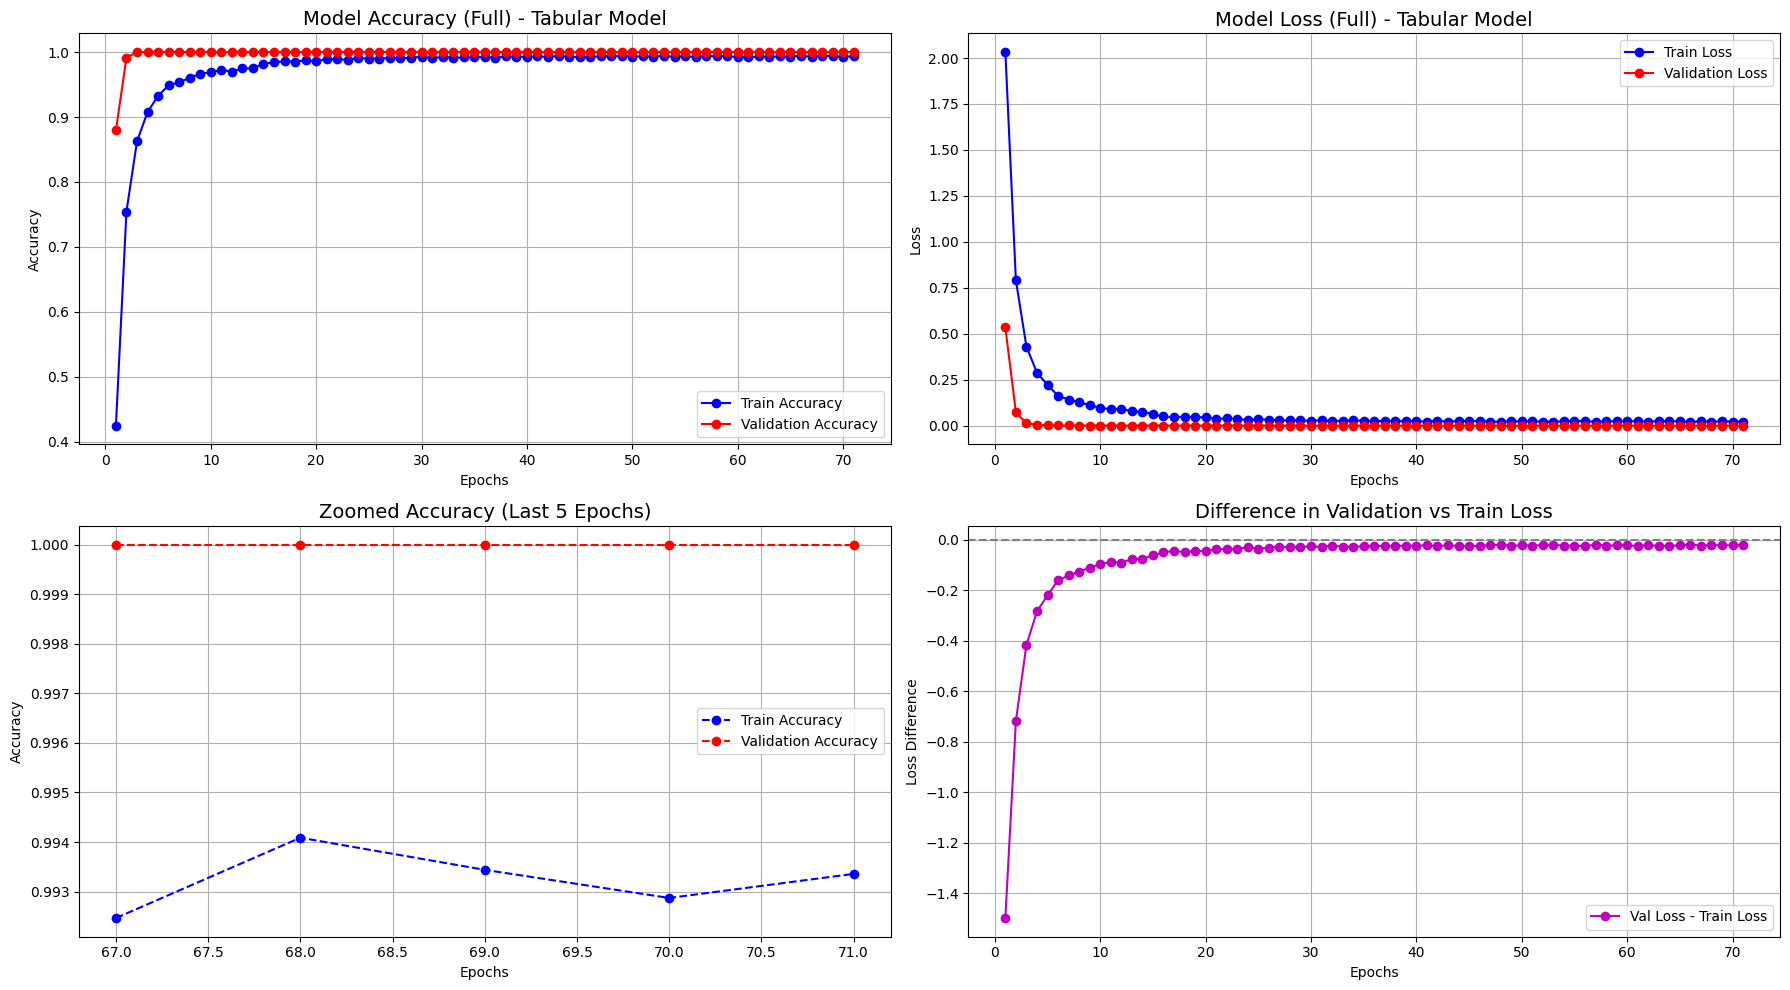

In [22]:
# Curvas de Entrenamiento
acc_tab = history_tabular.history['accuracy']
val_acc_tab = history_tabular.history['val_accuracy']
loss_tab = history_tabular.history['loss']
val_loss_tab = history_tabular.history['val_loss']
epochs_range_tab = range(1, len(acc_tab) + 1)

plt.figure(figsize=(18, 10))

# 1. Full Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(epochs_range_tab, acc_tab, 'bo-', label='Train Accuracy')
plt.plot(epochs_range_tab, val_acc_tab, 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy (Full) - Tabular Model', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. Full Loss Plot
plt.subplot(2, 2, 2)
plt.plot(epochs_range_tab, loss_tab, 'bo-', label='Train Loss')
plt.plot(epochs_range_tab, val_loss_tab, 'ro-', label='Validation Loss')
plt.title('Model Loss (Full) - Tabular Model', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. Zoomed-in Accuracy (Last 5 Epochs)
if len(epochs_range_tab) >= 5:
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range_tab[-5:], acc_tab[-5:], 'bo--', label='Train Accuracy')
    plt.plot(epochs_range_tab[-5:], val_acc_tab[-5:], 'ro--', label='Validation Accuracy')
    plt.title('Zoomed Accuracy (Last 5 Epochs)', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# 4. Train vs. Validation Loss Difference
plt.subplot(2, 2, 4)
loss_diff_tab = np.array(val_loss_tab) - np.array(loss_tab)
plt.plot(epochs_range_tab, loss_diff_tab, 'mo-', label='Val Loss - Train Loss')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Difference in Validation vs Train Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()